<a href="https://colab.research.google.com/github/xavierloreto/assigment2_aaa/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [214]:
def load_and_preprocess_data(path):
    # Load and parse dates
    df = pd.read_csv(path, parse_dates=['date'], dayfirst=True)


    # Add year-month column for grouping
    df['year_month'] = df['date'].dt.to_period('M')
    #print(df)

    # Monthly aggregation (median)
    monthly = df.groupby('year_month').median().reset_index()
    monthly['year_month'] = monthly['year_month'].dt.to_timestamp()
    #print(monthly)

    return monthly

In [215]:

def create_lagged_features(df, target_column, n_lags=12):
    df_lagged = pd.DataFrame()
    for lag in range(n_lags + 1):
        shifted = df.drop(columns=[target_column]).shift(lag)
        shifted.columns = [f"{col}_lag{lag}" for col in shifted.columns]
        df_lagged = pd.concat([df_lagged, shifted], axis=1)

    # The target is at lag 0 (current month)
    df_lagged[target_column] = df[target_column].values
    df_lagged['group'] = np.arange(len(df_lagged))  # Each month = 1 group

    # Drop rows with NaNs from lagging
    df_lagged = df_lagged.dropna().reset_index(drop=True)

    #print(df_lagged)
    return df_lagged

In [216]:
def build_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

In [217]:
def evaluate_model(X, y, groups):
    cv = GroupKFold(n_splits=5)
    pipeline = build_pipeline()
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', groups=groups, error_score='raise')
    rmse_scores = np.sqrt(-scores)

    plot_actual_vs_predicted(X, y, pipeline, cv)
    return rmse_scores

In [218]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(X, y, pipeline, cv):
    groups = np.arange(len(X))

    # Store actual and predicted values
    y_actual = []
    y_predicted = []

    for train_idx, test_idx in cv.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training set
        pipeline.fit(X_train, y_train)

        # Predict on the test set
        y_pred = pipeline.predict(X_test)

        # Store the actual and predicted values
        y_actual.extend(y_test)
        y_predicted.extend(y_pred)

    # Convert lists to numpy arrays for easier plotting
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, color='blue', alpha=0.7, edgecolors='k')
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Groundwater Depth')
    plt.grid(True)
    plt.show()

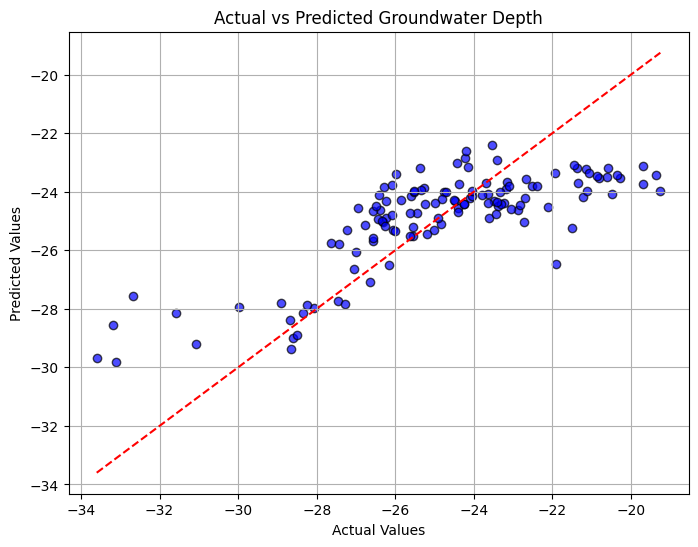

Cross-validated RMSE scores: [1.82045303 1.69448656 1.79431455 2.00721558 2.00090837]
Mean RMSE: 1.8634756172313538


In [219]:
def main():
    data_path = "https://raw.githubusercontent.com/isa-ulisboa/greends-pml/refs/heads/main/data/aquifer_time_series.csv"  # Adjust path if needed
    df = load_and_preprocess_data(data_path)

    target = 'depth_to_groundwater_m'
    lagged = create_lagged_features(df, target_column=target, n_lags=12)

    datetime_cols = lagged.select_dtypes(include=['datetime64[ns]']).columns
    x = lagged.drop(columns=datetime_cols.union(['group', target]))
    y = lagged[target]
    groups = lagged['group']

    scores = evaluate_model(x, y, groups)
    print("Cross-validated RMSE scores:", scores)
    print("Mean RMSE:", np.mean(scores))

if __name__ == "__main__":
    main()